# Lane Detection with TuSimple Dataset
Using U-Net
1. Configuration
2. Data Preprocessing (JSON to Masks)
3. Dataset Loading
4. Model Architecture (U-Net)
5. Training Loop
6. Inference & Visualization
7. Execution
8. Evaluation

Save the Confusion Matrix while the validation

differentiation of lanes: arc loss, distance between lanes. 
last layer 
instance segmentation

+3 credits: from instance segmentation -> shape of lane markings scipy make_splprep

## 1. Configuration
Define paths, hyperparameters, and device settings.


In [20]:
import os
import json
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

BASE_DIR = os.getcwd()
DATA_DIR = r'C:\ADAS_Project\TUSimple_Small' 
TRAIN_SET_DIR = os.path.join(DATA_DIR, 'train_set')
TEST_SET_DIR = os.path.join(DATA_DIR, 'test_set')
PROCESSED_DATA_DIR = os.path.join(DATA_DIR, r'processed\binary')
CHECKPOINT_DIR = os.path.join(BASE_DIR, r'checkpoints\binary')

os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Hyperparameters
EPOCHS = 20 #20+ for final training
BATCH_SIZE = 8 # calculate based on GPU memory (for kaggle TP4*2, 16 or 32)
LEARNING_RATE = 5*1e-4 #for kaggle, 1e-4 works well 
WEIGHT_DECAY = 1e-4 
NUM_CLASSES = 2  # background + all lanes 
IMG_HEIGHT = 288 # resize target height
IMG_WIDTH = 512  # resize target width

# save model checkpoints
model_filename = f'best_model_binary_e{EPOCHS}.pth'
BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, model_filename)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Data Preprocessing
Functions to parse TuSimple JSON labels and generate segmentation masks.


In [21]:
def process_tusimple_data(data_dir, output_dir, json_files):
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for json_file in json_files:
        json_path = os.path.join(data_dir, json_file)

        with open(json_path, 'r') as openfile: #read json file 
            lines = openfile.readlines()

        for line in tqdm(lines, desc=f"Processing {json_file}"):
            info = json.loads(line)
            raw_file = info['raw_file']
            lanes = info['lanes']
            h_samples = info['h_samples']
            
            # create mask assuming 1280x720
            mask = np.zeros((720, 1280), dtype=np.uint8)

            # filter out empty lanes, -2 for no lane
            valid_lanes = []
            for lane in lanes:
                if any(x != -2 for x in lane):
                    valid_lanes.append(lane)
            
            # binary: draw all valid lanes with class ID 1
            for lane in valid_lanes:
                points = []
                for x, y in zip(lane, h_samples):
                    if x != -2:
                        points.append((x, y))
                
                if len(points) > 1:
                    cv2.polylines(mask, [np.array(points, dtype=np.int32)], isClosed=False, color=1, thickness=10)
                    
            # save mask
            mask_rel_path = raw_file.replace('.jpg', '.png')
            mask_save_path = os.path.join(output_dir, mask_rel_path)
            
            os.makedirs(os.path.dirname(mask_save_path), exist_ok=True)
            cv2.imwrite(mask_save_path, mask)


## 3. Dataset Definition
PyTorch Dataset class to load images and masks.


In [22]:
class TuSimpleDataset(Dataset):
    def __init__(self, root_dir, processed_dir, json_files, transform=None):
        self.root_dir = root_dir
        self.processed_dir = processed_dir
        self.transform = transform
        self.samples = []

        # load all samples from json files
        for json_file in json_files:
            json_path = os.path.join(root_dir, json_file)
            if not os.path.exists(json_path):
                continue
                
            with open(json_path, 'r') as f:
                lines = f.readlines()
            
            for line in lines:
                info = json.loads(line)
                raw_file = info['raw_file']
                mask_file = raw_file.replace('.jpg', '.png')
                
                self.samples.append((raw_file, mask_file))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_rel_path, mask_rel_path = self.samples[idx]
        
        img_path = os.path.join(self.root_dir, img_rel_path)
        mask_path = os.path.join(self.processed_dir, mask_rel_path)
        
        # load image and mask
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # resize and normalize
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)

        image = image.astype(np.float32) / 255.0
        image = np.transpose(image, (2, 0, 1)) # channel first
      
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).long()
        
        return image, mask


## 4. Model Architecture (U-Net)

DoubleConv - from original UNet architecture

In [23]:
class DoubleConv(nn.Module):
    #(convolution => [BN] => ReLU) * 2
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # padding=1
        mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


Encoder - downsampling:

In [24]:
class Down(nn.Module):
    #downscaling with maxpool then double conv    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # 256x256 -> 128x128
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


Decoder - upsampling:

In [25]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # upsample  
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # x1 previous layer 
        # x2 corresponding encoder layer (skip connection)
        x1 = self.up(x1)
        
        # calculate the difference in size between x1 (upsampled) and x2 (skip connection)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        # Pad x1 to match the size of x2
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        # skip connection
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [26]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        # 1x1 convolution to map feature channels to the number of classes
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

Final:

In [27]:
class UNet(nn.Module): 
    #full unet
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # define encoder sizes
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        # define decoder sizes
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # encoder 
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # decoder - with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # final
        out = self.outc(x) 
        return out

## 5. Training Loop


In [28]:
def train_model():
    # dataset
    json_files = ['label_data_0313.json', 'label_data_0531.json', 'label_data_0601.json']
    
    full_dataset = TuSimpleDataset(TRAIN_SET_DIR, PROCESSED_DATA_DIR, json_files)

    # split into train and val
    train_size = int(0.9 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # model
    model = UNet(n_channels=3, n_classes=NUM_CLASSES).to(device) #3 channels for R,G,B 

    # loss and optimizer
    class_weights = torch.tensor([0.5, 1.0], device=device) # background, Lane
    criterion_ce = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)


    best_val_loss = float('inf') # checkpoint

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}") #tqdm is a progress bar
        
        for images, masks in loop:
            images = images.to(device)
            masks = masks.to(device)

            # forward pass
            outputs = model(images)

            loss_ce = criterion_ce(outputs, masks)
            loss = loss_ce

            # backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_postfix(loss=loss.item(), ce=loss_ce.item())

        avg_train_loss = train_loss / len(train_loader)
        
        # validation, no_grad for validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                
                loss_ce = criterion_ce(outputs, masks)
                loss = loss_ce
                
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            print("Saved best model checkpoint.")


## 6. Inference & Visualization


In [29]:
def lane_detection_prediction(image_path, model_path, output_path):
    # load model
    model = UNet(n_channels=3, n_classes=NUM_CLASSES).to(device) #3 channels for rgb images
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # load image
    example_image = cv2.imread(image_path)
    
    image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB) #convert to RGB
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT)) #resize to match input size
    image = image.astype(np.float32) / 255.0 #normalize
    image = np.transpose(image, (2, 0, 1)) #channels first
    image = torch.from_numpy(image).float().unsqueeze(0).to(device) 

    # inference
    with torch.no_grad():
        output = model(image)
        probs = torch.softmax(output, dim=1)
        pred_mask = torch.argmax(probs, dim=1).squeeze(0).cpu().numpy()
    
    # visualization
    pred_mask_resized = cv2.resize(pred_mask.astype(np.uint8), (example_image.shape[1], example_image.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    #for binary seg -> one lane class 
    colors = [
        [0, 0, 0],       # Background
        [0, 255, 0]      # Lane (Green)
    ]
    
    overlay = np.zeros_like(example_image)
    for i in range(1, NUM_CLASSES):
        overlay[pred_mask_resized == i] = colors[i]

    result = cv2.addWeighted(example_image, 1, overlay, 0.5, 0) #overlay mask on original image

    cv2.imwrite(output_path, result)
    print(f"Saved result to {output_path}")
    
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

## 7. Execution
Execution of the training functions and inference. 


In [30]:
# 1. Run Preprocessing
json_files = ['label_data_0313.json', 'label_data_0531.json', 'label_data_0601.json']
process_tusimple_data(TRAIN_SET_DIR, PROCESSED_DATA_DIR, json_files)

Processing label_data_0601.json: 100%|██████████| 110/110 [00:00<00:00, 169.23it/s]


In [ ]:
# 2. Train Model
train_model()

Saved result to binary_result.jpg


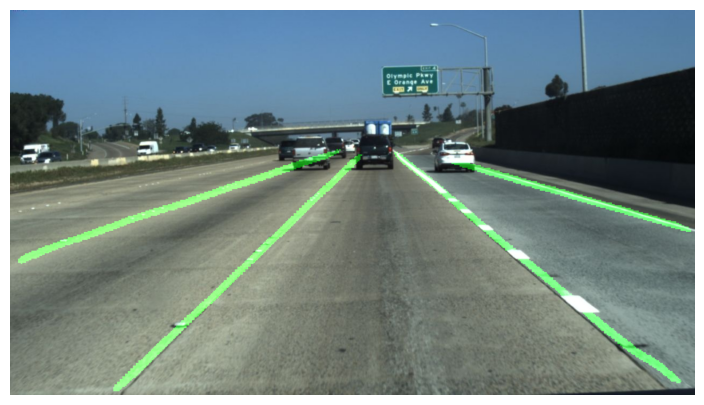

In [31]:
# 3. Inference
test_image_path = os.path.join(TRAIN_SET_DIR, 'clips/0313-2/50/10.jpg') # Example image
lane_detection_prediction(test_image_path, BEST_MODEL_PATH, 'binary_result.jpg')

## 8. Evaluation
Calculate IoU and Accuracy on the Test Set.


In [32]:
def calculate_iou(pred_mask, true_mask, num_classes):
    # pred_mask, true_mask: [H, W]
    iou_per_class = []
    
    # Binary usually has NUM_CLASSES=2 (Background, Lane)
    for classes in range(num_classes): 
        pred_classes = (pred_mask == classes)
        true_classes = (true_mask == classes)
        
        intersection = np.logical_and(pred_classes, true_classes).sum()
        union = np.logical_or(pred_classes, true_classes).sum()
        
        if union == 0:
            iou = np.nan 
        else:
            iou = intersection / union
          
        iou_per_class.append(iou)
        
    return iou_per_class


In [ ]:
def evaluate(model, test_loader, device):
    num_visualize = 3
    model.eval()
    total_iou = []
    
    viz_samples = []
    
    colors = [
        [0, 0, 0],       # Background
        [255, 0, 0]      # Lane (Red) - assuming Binary class 1 is the only lane
    ]
    
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.cpu().numpy()
            
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1).cpu().numpy()
            
            for i in range(len(masks)):
                iou = calculate_iou(preds[i], masks[i], NUM_CLASSES)
                total_iou.append(iou)
                
                if len(viz_samples) < num_visualize:
                    img_np = images[i].cpu().permute(1, 2, 0).numpy()
                    img_np = (img_np * 255).astype(np.uint8)
                    img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR) 
                    img_np_rgb = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
                    
                    # For binary, usually interest is only class 1
                    iou_val = iou[1] if len(iou) > 1 else iou[0]
                    
                    viz_samples.append((img_np_rgb, masks[i], preds[i], iou_val))
    
    mean_iou_per_class = np.nanmean(total_iou, axis=0)
    
    print(f"Mean IoU per class (BG, Lane): {mean_iou_per_class}")
    
    # Visualization
    fig, axes = plt.subplots(num_visualize, 3, figsize=(15, 5 * num_visualize))
    
    for idx, (img, gt, pred, iou) in enumerate(viz_samples):
        current_axes = axes[idx]
        
        ax_input = current_axes[0]
        ax_input.imshow(img)
        ax_input.set_title("Input Image")
        ax_input.axis('off')
        
        # GT
        overlay_gt = img.copy()
        if np.any(gt == 1):
            overlay_gt[gt == 1] = colors[1]
        ax_gt = current_axes[1]
        ax_gt.imshow(overlay_gt)
        ax_gt.set_title("Ground Truth")
        ax_gt.axis('off')
        
        # Pred
        overlay_pred = img.copy()
        if np.any(pred == 1):
            overlay_pred[pred == 1] = colors[1]
        ax_pred = current_axes[2]
        ax_pred.imshow(overlay_pred)
        
        if np.isnan(iou):
             ax_pred.set_title("Prediction (No Lanes)")
        else:
             ax_pred.set_title(f"Prediction (Lane IoU: {iou:.3f})")
        ax_pred.axis('off')
    
    plt.tight_layout()
    plt.show()


Processing test_label.json:   0%|          | 0/278 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 35/35 [00:23<00:00,  1.52it/s]



--- Evaluation Results ---
Mean IoU per class (BG, Lane): [0.98397506 0.58548396]


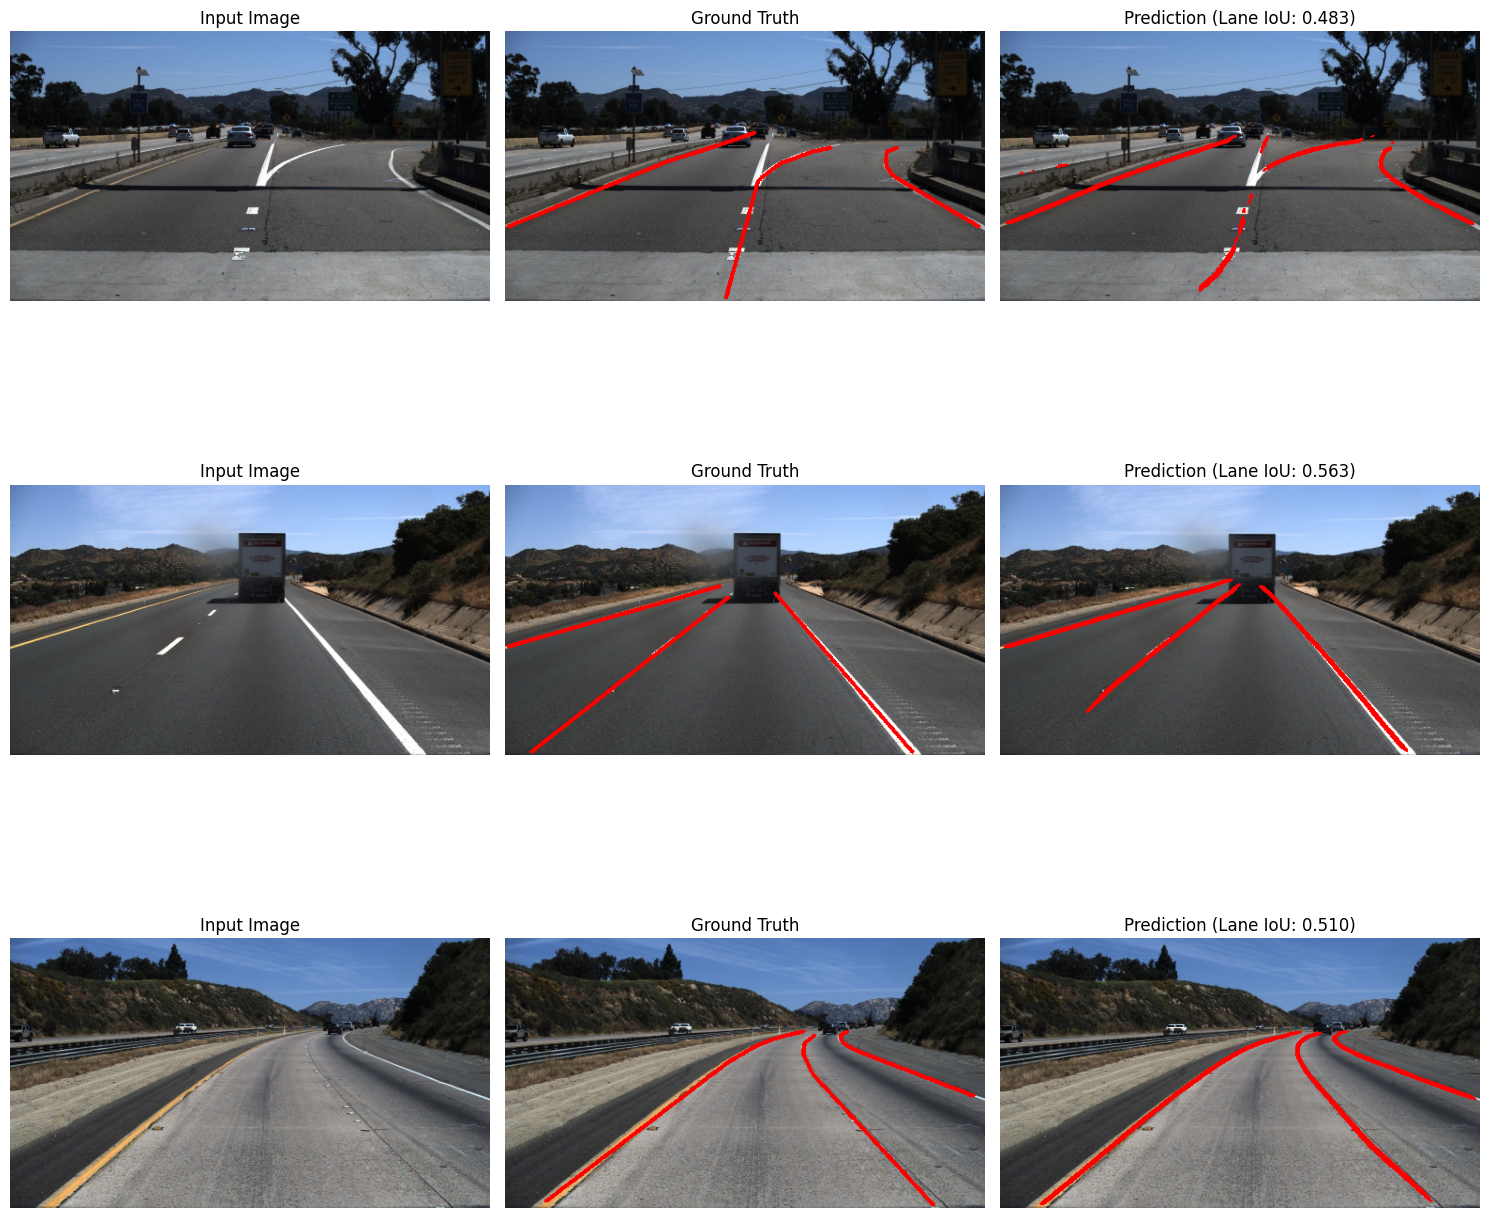

In [34]:
test_json_files = ['test_label.json']
process_tusimple_data(TEST_SET_DIR, PROCESSED_DATA_DIR, test_json_files)

test_dataset = TuSimpleDataset(TEST_SET_DIR, PROCESSED_DATA_DIR, test_json_files)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UNet(n_channels=3, n_classes=NUM_CLASSES).to(device) #3 channels for rgb images
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))

evaluate(model, test_loader, device)
